<a href="https://colab.research.google.com/github/trisharangi/multi-modal-sentiment-analysis-tweets-text-images-lmh2-25/blob/main/Multi_Modal_Sentiment_Analysis_(Tweets_Text_%2B_Images)_PART_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal Sentiment Analysis - Homework Assignment

![Combined Model Architecture](https://i.imgur.com/RVYyBe7.jpeg)

In this homework, you will build and compare three different models for sentiment analysis on a dataset of tweets, each containing both an image and text.

## 📌 Project Overview
- **Task**: Classify the sentiment of a tweet (positive, negative, or neutral) using its text, its image, and a combination of both.
- **Architecture**:
    1. An image-only model (CNN).
    2. A text-only model (RNN/LSTM/GRU).
    3. A combined, multi-modal model that fuses features from the two.
- **Dataset**: MVSA (Multi-view Social Data)
- **Goal**: Compare the performance of unimodal vs. multi-modal approaches for sentiment analysis.

## 📚 Learning Objectives
By completing this assignment, you will:
- Understand how to process a mixed-media dataset (images and text).
- Implement a CNN for image classification.
- Build an RNN/LSTM for text classification.
- Construct a multi-modal architecture by combining feature extractors.
- Evaluate and compare the performance of different models on the same task.

## 1️⃣ Dataset Setup (PROVIDED)

The MVSA dataset has been downloaded for you. The dataset structure is as follows:
- `labelResultAll.txt`: A file containing the labels for each data point. The format is `tweet_id,label`.
- `data/`: A folder containing all the image (`.jpg`) and text (`.txt`) files, named by their tweet ID.

In [ ]:
!pip install python_dotenv

In [ ]:
#IN THIS MODEL THE FIRST PART WORKS BETTER
import kagglehub
import os
from dotenv import load_dotenv

# Dataset already downloaded and prepared
load_dotenv()
path = kagglehub.dataset_download("vincemarcs/mvsasingle")
print("Path to dataset files:", path)

# Let's check the contents
print("\nContents of MVSA_Single:")
print(os.listdir(os.path.join(path, 'MVSA_Single')))

print("\nSample of files in the data folder:")
print(os.listdir(os.path.join(path, 'MVSA_Single', 'data'))[:5])

Path to dataset files: /kaggle/input/mvsasingle

Contents of MVSA_Single:
['data', 'labelResultAll.txt']

Sample of files in the data folder:
['1893.txt', '1711.txt', '4682.txt', '5064.txt', '3504.txt']


## 2️⃣ Import Libraries and Configuration

**Task**: Import all necessary libraries and set up configuration parameters.

**Requirements**:
- Import PyTorch, torchvision, pandas, and other utilities.
- Import libraries for text processing and evaluation (e.g., NLTK, Scikit-learn).
- Set random seeds for reproducibility.
- Configure hyperparameters with reasonable values.

In [ ]:
# Import all necessary libraries
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



# Text processing
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check device availability and print
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define configuration parameters
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
NUM_EPOCHS = 10
VOCAB_SIZE = 10000
MAX_LEN = 50

Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 3️⃣ Data Loading and Preprocessing

**Task**: Load the labels, match them with their corresponding image and text files, and split the data.

**Requirements**:
- Read `labelResultAll.txt` into a pandas DataFrame.
- Map labels from ('positive', 'negative', 'neutral') to (0, 1, 2).
- Create a list of all data samples, where each sample is a tuple `(image_path, text_path, label)`.
- Split this list into training and validation sets (e.g., 80:20 split).

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

dataset_dir = os.path.join(path, 'MVSA_Single')
text_dir = os.path.join(dataset_dir, 'data')
label_file = os.path.join(dataset_dir, 'labelResultAll.txt')

# Read labels, skipping the header row, and using tab separator
labels_df = pd.read_csv(label_file, skiprows=1, names=['id', 'label'], sep='\t')
print("Labels dataframe sample:")
print(labels_df.head())
print(f"Total labels read: {len(labels_df)}")

# Split the 'label' column into two separate labels (text, image)
labels_split = labels_df['label'].str.split(',', expand=True)
labels_df['text_label'] = labels_split[0]
labels_df['image_label'] = labels_split[1]

# Map string labels to integers (choose text_label or image_label as needed)
label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
labels_df['label_int'] = labels_df['text_label'].map(label_map)

print("Sample files in text_dir:")
print(os.listdir(text_dir)[:10])  # List first 10 files

data_samples = []
for idx, row in labels_df.iterrows():
    text_file = os.path.join(text_dir, f"{row['id']}.txt")
    image_file = os.path.join(text_dir, f"{row['id']}.jpg")
    if os.path.isfile(text_file) and os.path.isfile(image_file):
        data_samples.append((image_file, text_file, row['label_int']))
    else:
        print(f"Warning: Missing files for ID {row['id']}")

print(f"Total data samples found: {len(data_samples)}")

if len(data_samples) > 0:
    train_samples, val_samples = train_test_split(
        data_samples, test_size=0.2, random_state=42
    )
    print(f"Number of training samples: {len(train_samples)}")
    print(f"Number of validation samples: {len(val_samples)}")
else:
    print("No data samples found. Check file paths and extensions.")

Labels dataframe sample:
   id              label
0   1   neutral,positive
1   2   neutral,positive
2   3   neutral,positive
3   4  positive,positive
4   5  positive,positive
Total labels read: 4869
Sample files in text_dir:
['1893.txt', '1711.txt', '4682.txt', '5064.txt', '3504.txt', '1269.jpg', '3863.jpg', '1773.txt', '623.jpg', '559.txt']
Total data samples found: 4869
Number of training samples: 3895
Number of validation samples: 974


## 4️⃣ Text and Image Transformations

**Task**: Define the preprocessing pipelines for both images and text.

**Requirements**:
- For images: Define transforms to resize, convert to tensor, and normalize.
- For text:
    - Build a vocabulary from the training text data.
    - Create a text pipeline function to tokenize, numericalize (convert tokens to integers), and pad sequences.

In [ ]:
from torchvision import transforms
from collections import Counter
import re
import torch

# 1. Define image transforms using transforms.Compose
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.ColorJitter(
        brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 2. Build the text vocabulary from training data

# Clean regex-based tokenizer (replaces NLTK)
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())  # Lowercase and extract words

# Special tokens
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'

# Build vocabulary from training texts only
word_counter = Counter()
for _, text_path, _ in train_samples:
    with open(text_path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    tokens = tokenize(text)
    word_counter.update(tokens)

# Keep the most common VOCAB_SIZE - 2 (reserve 2 for PAD and UNK)
most_common_words = word_counter.most_common(VOCAB_SIZE - 2)

# Build vocab: word -> index mapping
vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
for idx, (word, _) in enumerate(most_common_words, start=2):
    vocab[word] = idx

print(f"Vocabulary size (including PAD and UNK): {len(vocab)}")

# 3. Define a text processing pipeline function
def process_text(text_path):
    with open(text_path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    tokens = tokenize(text)

    # Convert tokens to indices (use UNK index if word not in vocab)
    indices = [vocab.get(token, vocab[UNK_TOKEN]) for token in tokens]

    # Pad or truncate sequence to MAX_LEN
    if len(indices) < MAX_LEN:
        indices.extend([vocab[PAD_TOKEN]] * (MAX_LEN - len(indices)))
    else:
        indices = indices[:MAX_LEN]

    return torch.tensor(indices, dtype=torch.long)  # tensor of word indices

Vocabulary size (including PAD and UNK): 10000


## 5️⃣ Custom Dataset and DataLoaders

**Task**: Create a custom Dataset class and set up DataLoaders.

**Requirements**:
- The `Dataset` should handle loading one sample (image, text, and label).
- `__getitem__` should apply the image transforms and text processing pipeline.
- Create `DataLoader` instances for both training and validation sets.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class MVSADataset(Dataset):
    def __init__(self, data_samples, image_transform, text_pipeline):
        """
        data_samples: list of tuples (image_path, text_path, label)
        image_transform: torchvision transforms for image processing
        text_pipeline: function to process text file into tensor
        """
        self.data_samples = data_samples
        self.image_transform = image_transform
        self.text_pipeline = text_pipeline

    def __len__(self):
        return len(self.data_samples)

    def __getitem__(self, idx):
        image_path, text_path, label = self.data_samples[idx]

        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        processed_image = self.image_transform(image)

        # Process text file
        processed_text = self.text_pipeline(text_path)

        return processed_image, processed_text, label

# Create datasets
train_dataset = MVSADataset(train_samples, image_transforms, process_text)
val_dataset = MVSADataset(val_samples, image_transforms, process_text)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 6️⃣ Part A: Image-Only Model (CNN)

First, we will build, train, and evaluate a model that only uses the images to predict sentiment.

### 6.1 Define the CNN Architecture
**Task**: Create a CNN for image classification. A pre-trained model like ResNet is a good choice.

**Requirements**:
- Load a pre-trained ResNet (e.g., ResNet18).
- Replace the final fully connected layer to match the number of sentiment classes (3).

In [ ]:
import torch.nn as nn
from torchvision import models

class ImageModel(nn.Module):
    def __init__(self, num_classes=3):
        super(ImageModel, self).__init__()
        self.model = models.resnet18(pretrained=True)

        # Freeze all layers initially
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace final layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)
# Initialize and move to device
image_model = ImageModel(num_classes=3).to(device)

# Print model architecture
print(image_model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ImageModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

### 6.2 Train and Evaluate the Image Model
**Task**: Write the training and evaluation loop for the image-only model.

**Requirements**:
- Set up the loss function (CrossEntropyLoss) and optimizer (Adam).
- Loop through epochs and batches to train the model.
- After training, evaluate the model's performance on the validation set.
- Calculate and display the final accuracy and a confusion matrix.

Epoch 1/10 | Train Loss: 1.0830 | Train Acc: 41.21% | Val Loss: 1.0653 | Val Acc: 41.27%
Epoch 2/10 | Train Loss: 1.0586 | Train Acc: 44.36% | Val Loss: 1.0608 | Val Acc: 41.68%
Epoch 3/10 | Train Loss: 1.0384 | Train Acc: 44.96% | Val Loss: 1.0573 | Val Acc: 41.89%
Epoch 4/10 | Train Loss: 1.0263 | Train Acc: 46.29% | Val Loss: 1.0573 | Val Acc: 41.27%
Epoch 5/10 | Train Loss: 1.0040 | Train Acc: 48.14% | Val Loss: 1.0621 | Val Acc: 43.02%
Epoch 6/10 | Train Loss: 0.9834 | Train Acc: 50.99% | Val Loss: 1.0796 | Val Acc: 42.09%
Epoch 7/10 | Train Loss: 0.9482 | Train Acc: 53.61% | Val Loss: 1.1063 | Val Acc: 42.51%
Epoch 8/10 | Train Loss: 0.9296 | Train Acc: 54.35% | Val Loss: 1.1147 | Val Acc: 41.89%
Epoch 9/10 | Train Loss: 0.8736 | Train Acc: 58.82% | Val Loss: 1.1523 | Val Acc: 44.46%
Epoch 10/10 | Train Loss: 0.8279 | Train Acc: 61.80% | Val Loss: 1.1685 | Val Acc: 41.99%

Classification Report (Validation Set):
              precision    recall  f1-score   support

    positive 

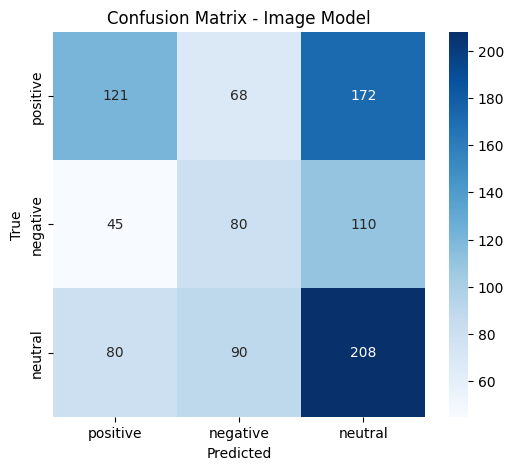

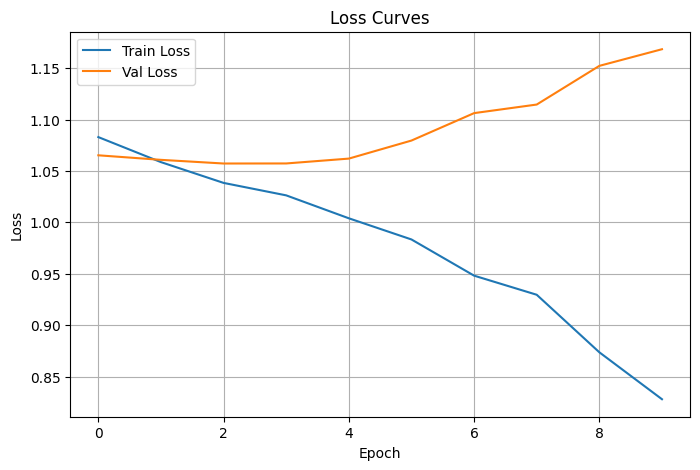

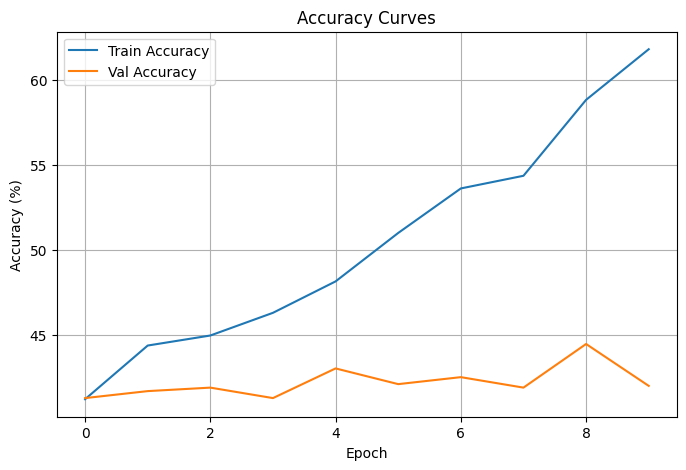

In [ ]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Instantiate loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [] , []

for epoch in range(NUM_EPOCHS):
    # === TRAINING ===
    image_model.train()
    running_loss = 0.0
    train_preds = []
    train_labels = []

    for images, _, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = image_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds) * 100  # percentage

    # === VALIDATION ===
    image_model.eval()
    val_loss_total = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, _, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = image_model(images)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = val_loss_total / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds) * 100  # percentage

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print metrics
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} "
          f"| Train Loss: {train_loss:.4f} "
          f"| Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f} "
          f"| Val Acc: {val_acc:.2f}%")

# === POST-TRAINING EVALUATION ===
print("\nClassification Report (Validation Set):")
print(classification_report(val_labels, val_preds, target_names=['positive', 'negative', 'neutral']))

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Image Model')
plt.show()

# === Loss Plot ===
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curves")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# === Accuracy Plot ===
plt.figure(figsize=(8,5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curves")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

## 7️⃣ Part B: Text-Only Model (RNN/LSTM)

Next, we will build a model that uses only the text from the tweets.

### 7.1 Define the RNN/LSTM Architecture
**Task**: Create a text classification model using an Embedding layer and an LSTM/GRU layer.

**Requirements**:
- An `nn.Embedding` layer to convert word indices to dense vectors.
- An `nn.LSTM` or `nn.GRU` layer to process the sequence.
- A final `nn.Linear` layer to produce class scores.

In [ ]:
import torch.nn as nn

class TextModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, output_dim=3, num_layers=2):
        super(TextModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # ×2 for bidirectional

    def forward(self, text):
        embedded = self.embedding(text)  # (batch_size, seq_len, embedding_dim)
        _, (hidden, _) = self.lstm(embedded)  # hidden shape: (num_layers*2, batch_size, hidden_dim)

        # Concatenate last forward and backward hidden states
        forward_hidden = hidden[-2]  # last layer forward
        backward_hidden = hidden[-1] # last layer backward
        hidden_cat = torch.cat((forward_hidden, backward_hidden), dim=1)  # (batch_size, hidden_dim*2)

        output = self.fc(hidden_cat)  # (batch_size, output_dim)
        return output

### 7.2 Train and Evaluate the Text Model
**Task**: Train and evaluate the text-only model using the same process as before.

Epoch 1/10: 100%|██████████| 122/122 [00:48<00:00,  2.53it/s]


Epoch [1/10] - Train Loss: 0.8491 | Train Acc: 65.03% - Val Loss: 0.9686 | Val Acc: 55.34%


Epoch 2/10: 100%|██████████| 122/122 [00:47<00:00,  2.55it/s]


Epoch [2/10] - Train Loss: 0.8434 | Train Acc: 65.31% - Val Loss: 0.9688 | Val Acc: 54.72%


Epoch 3/10: 100%|██████████| 122/122 [00:48<00:00,  2.50it/s]


Epoch [3/10] - Train Loss: 0.8396 | Train Acc: 65.42% - Val Loss: 0.9686 | Val Acc: 54.62%


Epoch 4/10: 100%|██████████| 122/122 [00:48<00:00,  2.52it/s]


Epoch [4/10] - Train Loss: 0.8361 | Train Acc: 65.85% - Val Loss: 0.9692 | Val Acc: 55.75%


Epoch 5/10: 100%|██████████| 122/122 [00:48<00:00,  2.51it/s]


Epoch [5/10] - Train Loss: 0.8318 | Train Acc: 66.06% - Val Loss: 0.9675 | Val Acc: 55.54%


Epoch 6/10: 100%|██████████| 122/122 [00:48<00:00,  2.52it/s]


Epoch [6/10] - Train Loss: 0.8291 | Train Acc: 66.24% - Val Loss: 0.9707 | Val Acc: 55.34%


Epoch 7/10: 100%|██████████| 122/122 [00:48<00:00,  2.53it/s]


Epoch [7/10] - Train Loss: 0.8247 | Train Acc: 66.83% - Val Loss: 0.9699 | Val Acc: 55.44%


Epoch 8/10: 100%|██████████| 122/122 [00:48<00:00,  2.51it/s]


Epoch [8/10] - Train Loss: 0.8225 | Train Acc: 67.29% - Val Loss: 0.9704 | Val Acc: 55.95%


Epoch 9/10: 100%|██████████| 122/122 [00:48<00:00,  2.50it/s]


Epoch [9/10] - Train Loss: 0.8194 | Train Acc: 67.06% - Val Loss: 0.9681 | Val Acc: 55.85%


Epoch 10/10: 100%|██████████| 122/122 [00:49<00:00,  2.45it/s]


Epoch [10/10] - Train Loss: 0.8160 | Train Acc: 67.55% - Val Loss: 0.9691 | Val Acc: 55.95%


Evaluating: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]



Classification Report (Text Model):
              precision    recall  f1-score   support

    positive       0.64      0.57      0.60       361
    negative       0.44      0.33      0.38       235
     neutral       0.55      0.70      0.61       378

    accuracy                           0.56       974
   macro avg       0.54      0.53      0.53       974
weighted avg       0.56      0.56      0.55       974

Validation Accuracy (Text Model): 55.95%


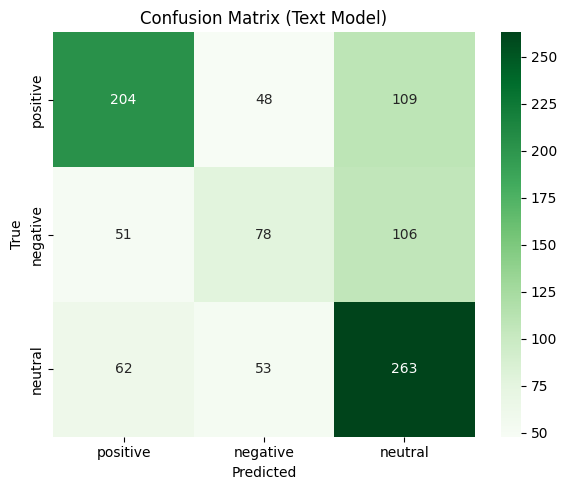

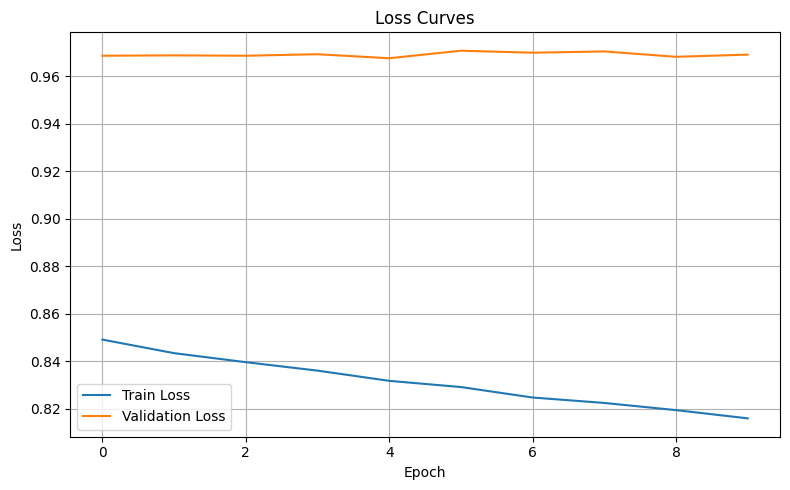

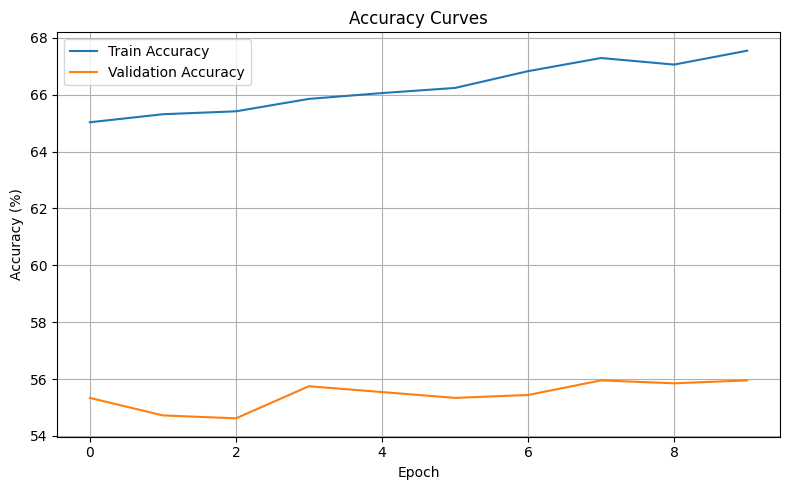

In [ ]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Instantiate loss function and optimizer for the text model
criterion_text = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_text = optim.Adam(text_model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer_text, step_size=3, gamma=0.9)

# Tracking metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    text_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        texts = texts.to(device)
        labels = labels.to(device)

        optimizer_text.zero_grad()
        outputs = text_model(texts)
        loss = criterion_text(outputs, labels)
        loss.backward()
        optimizer_text.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation phase
    text_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, texts, labels in val_loader:
            texts = texts.to(device)
            labels = labels.to(device)

            outputs = text_model(texts)
            loss = criterion_text(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Append loss and accuracy
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% - "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    scheduler.step()

# Final evaluation
text_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, texts, labels in tqdm(val_loader, desc="Evaluating"):
        texts = texts.to(device)
        labels = labels.to(device)

        outputs = text_model(texts)
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("\nClassification Report (Text Model):")
print(classification_report(all_labels, all_preds, target_names=['positive', 'negative', 'neutral']))

# Validation accuracy
val_acc = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy (Text Model): {val_acc * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Text Model)')
plt.tight_layout()
plt.show()

# Loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 8️⃣ Part C: Combined Multimodal Model

Finally, we'll combine the two feature extractors into a single, powerful model.

### 8.1 Define the Multimodal Architecture
**Task**: Create a model that takes both an image and text as input.

**Requirements**:
- Use the pre-trained image CNN (without its final classifier layer) as an image feature extractor.
- Use the trained text model (without its final classifier layer) as a text feature extractor.
- Concatenate the features from both branches.
- Add one or more `nn.Linear` layers to classify the combined feature vector.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# === Multimodal Model Definition ===
class MultiModalModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(MultiModalModel, self).__init__()

        # Image feature extractor: Pretrained ResNet18 without classification head
        resnet = models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        self.image_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Exclude final FC
        self.image_feature_dim = resnet.fc.in_features  # Typically 512

        # Text feature extractor: Embedding + LSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.text_feature_dim = hidden_dim

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.image_feature_dim + self.text_feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, text):
        image_features = self.image_extractor(image)
        image_features = image_features.view(image_features.size(0), -1)

        embedded = self.embedding(text)
        _, (hidden, _) = self.lstm(embedded)
        text_features = hidden[-1]

        combined_features = torch.cat((image_features, text_features), dim=1)
        return self.classifier(combined_features)

# === Model Initialization ===
VOCAB_SIZE = 10000
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
NUM_CLASSES = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
multimodal_model = MultiModalModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)

# === Class Weighting ===
label_counter = Counter([label for _, _, label in train_samples])
print("Training label distribution:", label_counter)

total = sum(label_counter.values())
weights = [total / label_counter[i] for i in range(NUM_CLASSES)]
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Training label distribution: Counter({2: 1543, 0: 1370, 1: 982})


### 8.2 Train and Evaluate the Multimodal Model
**Task**: Train and evaluate the final combined model.

Epoch [1/10] | Train Loss: 1.1089 | Train Acc: 33.30% | Val Loss: 1.1017 | Val Acc: 34.70%
Epoch [2/10] | Train Loss: 1.1071 | Train Acc: 35.53% | Val Loss: 1.1027 | Val Acc: 34.09%
Epoch [3/10] | Train Loss: 1.1030 | Train Acc: 35.92% | Val Loss: 1.0972 | Val Acc: 34.39%
Epoch [4/10] | Train Loss: 1.0997 | Train Acc: 36.71% | Val Loss: 1.0931 | Val Acc: 35.83%
Epoch [5/10] | Train Loss: 1.0978 | Train Acc: 36.94% | Val Loss: 1.0917 | Val Acc: 36.76%
Epoch [6/10] | Train Loss: 1.0967 | Train Acc: 36.69% | Val Loss: 1.0939 | Val Acc: 34.39%
Epoch [7/10] | Train Loss: 1.0977 | Train Acc: 36.66% | Val Loss: 1.0968 | Val Acc: 35.42%
Epoch [8/10] | Train Loss: 1.0944 | Train Acc: 37.20% | Val Loss: 1.0992 | Val Acc: 34.50%
Epoch [9/10] | Train Loss: 1.0936 | Train Acc: 37.69% | Val Loss: 1.0934 | Val Acc: 37.99%
Epoch [10/10] | Train Loss: 1.0939 | Train Acc: 37.30% | Val Loss: 1.0929 | Val Acc: 36.45%

Classification Report (Validation Set):
              precision    recall  f1-score   su

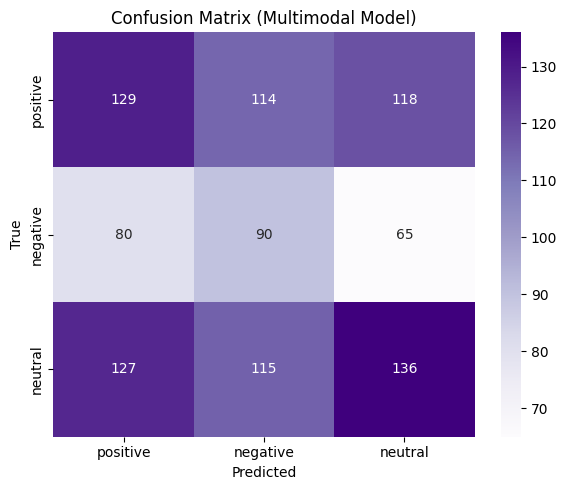

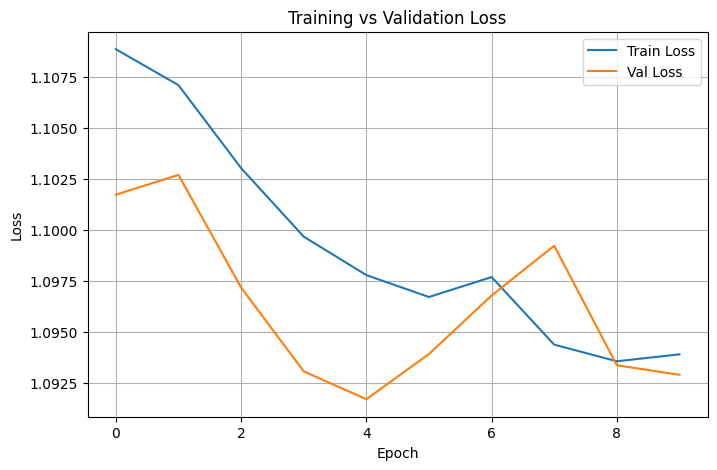

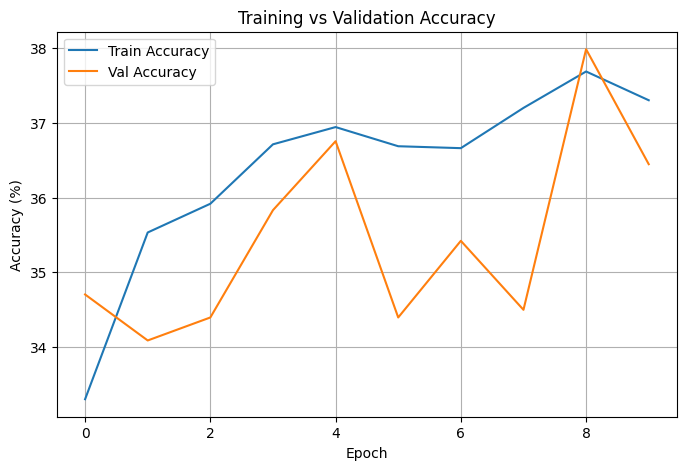

In [ ]:
# === Loss Function, Optimizer, Scheduler ===
criterion_multi = nn.CrossEntropyLoss(weight=class_weights)
optimizer_multi = optim.Adam(multimodal_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_multi, step_size=3, gamma=0.5)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []  # <-- NEW

# === Training Loop ===
for epoch in range(NUM_EPOCHS):
    # --- TRAINING ---
    multimodal_model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for images, texts, labels in train_loader:
        images, texts, labels = images.to(device), texts.to(device), labels.to(device)

        optimizer_multi.zero_grad()
        outputs = multimodal_model(images, texts)
        loss = criterion_multi(outputs, labels)
        loss.backward()
        optimizer_multi.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds) * 100

    # --- VALIDATION ---
    multimodal_model.eval()
    val_loss_total = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for images, texts, labels in val_loader:
            images, texts, labels = images.to(device), texts.to(device), labels.to(device)

            outputs = multimodal_model(images, texts)
            loss = criterion_multi(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = val_loss_total / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds) * 100

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)  # <-- NEW
    val_accuracies.append(val_acc)      # <-- NEW

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    scheduler.step()

# === Evaluation ===
print("\nClassification Report (Validation Set):")
print(classification_report(val_labels, val_preds, target_names=['positive', 'negative', 'neutral']))

cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Multimodal Model)')
plt.tight_layout()
plt.show()

# === Loss Plot ===
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# === Accuracy Plot ===
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 9️⃣ Performance Comparison

**Task**: Present the results of all three models side-by-side.

**Requirements**:
- Display the final validation accuracies for the Image-Only, Text-Only, and Multimodal models.
- Plot the confusion matrices for all three models in a single figure for easy comparison.

Validation Accuracy (Image Model): 0.4199
Validation Accuracy (Text Model): 0.5595
Validation Accuracy (Multimodal Model): 0.3676

Final Validation Accuracies:
Image Model Accuracy     : 0.4199
Text Model Accuracy      : 0.5595
Multimodal Model Accuracy: 0.3676


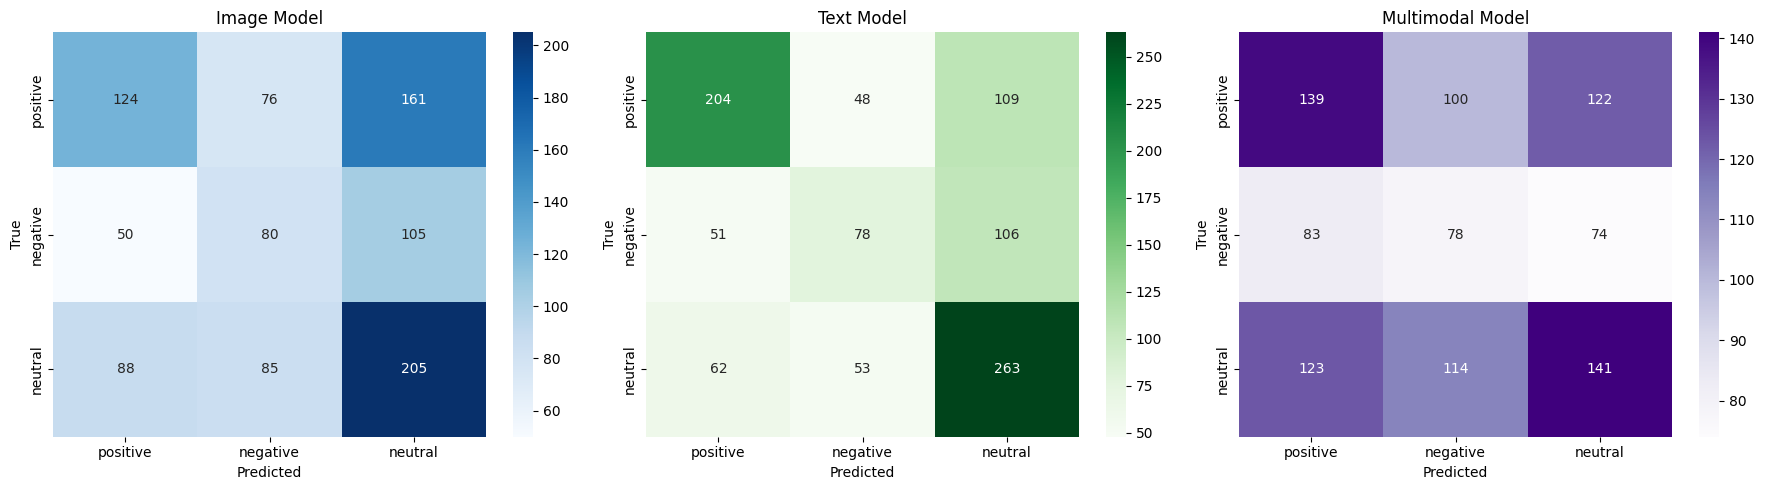

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Image Model Evaluation ===
image_model.eval()
image_all_preds = []
image_all_labels = []

with torch.no_grad():
    for images, texts, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = image_model(images)
        _, preds = torch.max(outputs, 1)

        image_all_preds.extend(preds.cpu().numpy())
        image_all_labels.extend(labels.cpu().numpy())

image_val_acc = accuracy_score(image_all_labels, image_all_preds)
print(f"Validation Accuracy (Image Model): {image_val_acc:.4f}")


# === Text Model Evaluation ===
text_model.eval()
text_all_preds = []
text_all_labels = []

with torch.no_grad():
    for images, texts, labels in val_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        outputs = text_model(texts)
        _, preds = torch.max(outputs, 1)

        text_all_preds.extend(preds.cpu().numpy())
        text_all_labels.extend(labels.cpu().numpy())

text_val_acc = accuracy_score(text_all_labels, text_all_preds)
print(f"Validation Accuracy (Text Model): {text_val_acc:.4f}")


# === Multimodal Model Evaluation ===
multimodal_model.eval()
multi_all_preds = []
multi_all_labels = []

with torch.no_grad():
    for images, texts, labels in val_loader:
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.to(device)

        outputs = multimodal_model(images, texts)
        _, preds = torch.max(outputs, 1)

        multi_all_preds.extend(preds.cpu().numpy())
        multi_all_labels.extend(labels.cpu().numpy())

multi_val_acc = accuracy_score(multi_all_labels, multi_all_preds)
print(f"Validation Accuracy (Multimodal Model): {multi_val_acc:.4f}")


# === Summary Table & Confusion Matrix Plots ===
print("\nFinal Validation Accuracies:")
print(f"Image Model Accuracy     : {image_val_acc:.4f}")
print(f"Text Model Accuracy      : {text_val_acc:.4f}")
print(f"Multimodal Model Accuracy: {multi_val_acc:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(confusion_matrix(image_all_labels, image_all_preds),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'],
            ax=axes[0])
axes[0].set_title('Image Model')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(confusion_matrix(text_all_labels, text_all_preds),
            annot=True, fmt='d', cmap='Greens',
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'],
            ax=axes[1])
axes[1].set_title('Text Model')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(confusion_matrix(multi_all_labels, multi_all_preds),
            annot=True, fmt='d', cmap='Purples',
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'],
            ax=axes[2])
axes[2].set_title('Multimodal Model')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

## 📝 Evaluation Criteria

Your homework will be evaluated based on:

1.  **Implementation Correctness (40%)**
    - Correct implementation of all three model architectures (CNN, RNN/LSTM, Combined).
    - Proper data loading, preprocessing, and splitting.
    - Working training and evaluation loops for each model.

2.  **Model Training and Results (30%)**
    - All three models train without errors.
    - Loss decreases over epochs.
    - Final models produce reasonable predictions on the validation set.

3.  **Code Quality (20%)**
    - Clean, readable code with comments explaining key parts.
    - Correct use of PyTorch modules, tensor shapes, and data flow.
    - Efficient implementation.

4.  **Comparison and Visualization (10%)**
    - Clear presentation of final accuracies for all models.
    - Correctly generated and clearly labeled confusion matrices for comparison.

# Written by: Ali Habibullah